<a href="https://colab.research.google.com/github/dibadabir/ML_Assignment/blob/main/Unsupervised_Face_Recognition_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! pip install face-recognition

In [3]:
# import neccassary libraries

import os  # OS interaction
import pickle  # Saving and loading models
import numpy as np  # Making numeric arrays
import cv2  # Displaying images
import face_recognition  # Face recognition
from PIL import Image  # Image processing
import matplotlib.pyplot as plt  # Plotting images
from google.colab.patches import cv2_imshow  # Image display in Colab
from sklearn.cluster import KMeans  # K-means clustering algorithm
from imutils import paths, build_montages  # Used to easily generate file paths to images in a folder


In [ ]:
def extract_frames(video_path):
    # Create folder to save frames
    video_name = video_path.split("/")[-1].split(".")[0]    # The video is saved with individuals name, this code extracts their name to use as label later
    folder_frames = f'/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Frames'
    os.makedirs(folder_frames, exist_ok=True)

    # Load the cascade face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Read the video file
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    save_count = 0      # Not saving all the frames

    while (cap.isOpened()):
        ret, frame = cap.read()

        # Break loop if video ends
        if ret == False:
            break

        # Convert frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        if(len(faces) > 0):
            # Save frame as an image file one out of three
            if save_count % 3 == 0:
                frame_filename = f"{video_name}.{frame_count}.jpg"
                frame_path = os.path.join(folder_frames, frame_filename)
                cv2.imwrite(frame_path, frame)
                print(frame_count)
                frame_count += 1

            save_count += 1

    # Release video capture object
    cap.release()
    cv2.destroyAllWindows()

    print(f"Total frames saved: {frame_count}")

In [ ]:
extract_frames('/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Diba.MOV')

In [ ]:
extract_frames('/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Jen.MOV')

In [ ]:
extract_frames('/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Saleh.MOV')

In [ ]:
extract_frames('/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Maciej.MOV')

# Uploading the extracted frames from videos and process them
Extracting face locations and encodings


In [4]:
# Specify paths

dataset_path = '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Frames'
encodings_path = '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Save Model/encodings.pickle'

# Saving images later
data = []

# Get image paths from dataset
imagePaths = list(paths.list_images(dataset_path))

# Loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
  print('[Info] processing images {}/{}'.format(i+1, len(imagePaths)))
  print(imagePaths)

  # Read the image
  image = cv2.imread(imagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Detect faces using face_recognition library
  boxes = face_recognition.face_locations(image)

  # Extract facial features encodings
  encodings = face_recognition.face_encodings(image, boxes)

  # Build dictionary of image's data
  d = [{'imagePath': imagePath, 'loc' : box, 'encoding' : enc}
       for (box,enc) in zip(boxes, encodings)]
  data.extend(d)

# Save encodings to file location
with open(encodings_path, 'wb') as f:
  pickle.dump(data, f)

print('Encoding of images saved in {}'.format(encodings_path))

[Info] processing images 1/141
['/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Frames/Diba.19.jpg', '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Frames/Diba.21.jpg', '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Frames/Diba.23.jpg', '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Frames/Diba.24.jpg', '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Frames/Diba.26.jpg', '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Frames/Diba.28.jpg', '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Frames/Diba.30.jpg', '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Frames/Diba.31.jpg', '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Frames/Diba.35.jpg', '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Frames/Diba.38.jpg', '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Frames/Diba.40.jpg', '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Frames/Diba.42.jpg', '/conten

# Feeding the data into the K-Means algorithm

In [5]:
# Specify paths

H = '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Save Model/encodings.pickle'
CLUSTERING_RESULT_PATH = '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Save Model/KMeans Clustering Result'

# Create clustering results directory if it doesn't exist
if not os.path.exists(CLUSTERING_RESULT_PATH):
  os.mkdir(CLUSTERING_RESULT_PATH)

# Load encodings
print('[Info] loading encodings...')
data = pickle.load(open(encodings_path, 'rb'))
data = np.array(data)
encodings = [d['encoding'] for d in data]

# Convert encoding to numpy array
encodings = np.array(encodings)

# Perform KMeans clustering
print('[Info] Clustering...')
kmeans = KMeans(n_clusters=4)     # We put 4 because we have 4 target but it can be changed to any other number with different data
labels = kmeans.fit_predict(encodings)

# Determine uniqe label IDs
labelIDs = np.unique(labels)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print('[Info] # unique face {}'.format(numUniqueFaces))

# Loop over unique label IDs
for labelID in labelIDs:
  print('[Info] faces for clustering: {}'.format(labelID))
  idxs = np.where(labels == labelID)[0]
  idxs = np.random.choice(idxs, size = min(25, len(idxs)), replace = False)#

  # Initialize list of faces
  faces = []

  # Loop over sampled indexes
  for i in idxs:
    image = cv2.imread(data[i]['imagePath'])
    (top, right, bottom, left) = data[i]['loc']
    face = image[top:bottom, left:right]

    # Resize face and add to faces list
    face = cv2.resize(face, (96,96), (5,5))
    faces.append(face)

  # Create montage
  montage = build_montages(faces, (96,96), (5,5))[0]

  # Save the output montage
  title = 'Cluster_{}'.format(labelID)
  cv2.imwrite(os.path.join(CLUSTERING_RESULT_PATH, title + '.jpg'), montage)

print('Clustering results saved in {}'.format(CLUSTERING_RESULT_PATH))

[Info] loading encodings...
[Info] Clustering...
[Info] # unique face 4
[Info] faces for clustering: 0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[Info] faces for clustering: 1
[Info] faces for clustering: 2
[Info] faces for clustering: 3
Clustering results saved in /content/drive/MyDrive/ML/Unsupervised - Face Recognition/Save Model/KMeans Clustering Result


# Save the model

In [6]:
# Save model to a file
model_save_path = '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Save Model/KMeans_model.pkl'
with open(model_save_path, 'wb') as f:
  pickle.dump(kmeans, f)

print(f'Kmeans model saved to {model_save_path}')


Kmeans model saved to /content/drive/MyDrive/ML/Unsupervised - Face Recognition/Save Model/KMeans_model.pkl


# Load the saved model

In [7]:
# Load the model
model_load_path = '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Save Model/KMeans_model.pkl'
with open(model_save_path, 'rb') as f:
  kmeans = pickle.load(f)

# Processing and making prediction on the unknown image
Define a function to extract the encodings of the unknown image and also making prediction with our loaded model

+Manually renaming the clusters based on the results

In [9]:
# Function to predict cluster name for a face encoding
def predict_cluster(encoding, kmeans_model, cluster_names):
    if encoding is not None:
        cluster_label = kmeans_model.predict([encoding])[0]
        cluster_name = cluster_names.get(cluster_label, f'Cluster {cluster_label}')
        return cluster_name
    else:
        return None

# Function to get face encodings and locations from an image
def get_face_encodings_and_locations(image_path):
    image = face_recognition.load_image_file(image_path)
    face_locations = face_recognition.face_locations(image)
    face_encodings = face_recognition.face_encodings(image, face_locations)
    return face_encodings, face_locations

# Manual cluster names
cluster_names = {           # Part should be manually done based on the cluster numbers
    0: "Maciej",
    1: "Diba",
    2: "Saleh",
    3: "Jennifer"
}

# Make prediction on image 1

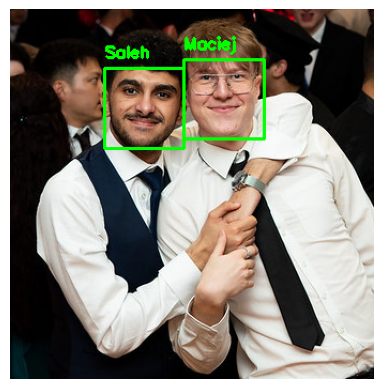

In [10]:
# Path to unknown image
unknown_image_path = '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/pred-1.PNG'

# Load the image
image = cv2.imread(unknown_image_path)

# Get face encodings and locations from the new image
face_encodings, face_locations = get_face_encodings_and_locations(unknown_image_path)

# Predict and display cluster labels for each face
for encoding, face_location in zip(face_encodings, face_locations):
    cluster_label = predict_cluster(encoding, kmeans, cluster_names)

    # Extract the coordinates of the face
    top, right, bottom, left = face_location

    # Draw a rectangle around the face
    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)

    # Write the predicted label on top of the rectangle
    cv2.putText(image, cluster_label, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convert BGR image to RGB for display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with rectangles and labels
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


# Make prediction on image 2

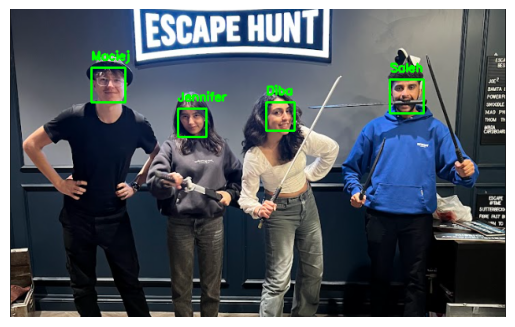

In [11]:
# Path to unknown image
unknown_image_path = '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/pred-2.PNG'

# Load the image
image = cv2.imread(unknown_image_path)

# Get face encodings and locations from the new image
face_encodings, face_locations = get_face_encodings_and_locations(unknown_image_path)

# Predict and display cluster labels for each face
for encoding, face_location in zip(face_encodings, face_locations):
    cluster_label = predict_cluster(encoding, kmeans, cluster_names)

    # Extract the coordinates of the face
    top, right, bottom, left = face_location

    # Draw a rectangle around the face
    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)

    # Write the predicted label on top of the rectangle
    cv2.putText(image, cluster_label, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convert BGR image to RGB for display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with rectangles and labels
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


# Bugs and further improvement
It detects and predicts all the faces in an image and try to refer it to the closest cluster

Recommended solution:

Predict labels based on a threshold

    if more than threshold:

          Make prediction
          
    else:
          Unknown

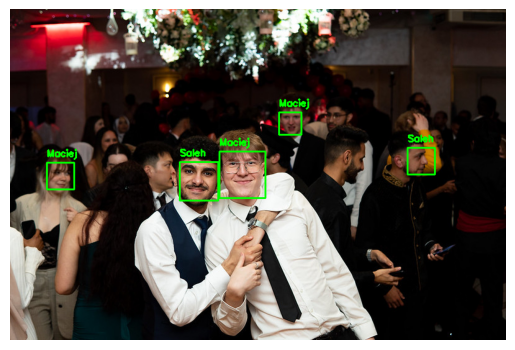

In [12]:
# Path to unknown image
unknown_image_path = '/content/drive/MyDrive/ML/Unsupervised - Face Recognition/Further Improvement.jpg'

# Load the image
image = cv2.imread(unknown_image_path)

# Get face encodings and locations from the new image
face_encodings, face_locations = get_face_encodings_and_locations(unknown_image_path)

# Predict and display cluster labels for each face
for encoding, face_location in zip(face_encodings, face_locations):
    cluster_label = predict_cluster(encoding, kmeans, cluster_names)

    # Extract the coordinates of the face
    top, right, bottom, left = face_location

    # Draw a rectangle around the face
    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)

    # Write the predicted label on top of the rectangle
    cv2.putText(image, cluster_label, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convert BGR image to RGB for display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with rectangles and labels
plt.imshow(image_rgb)
plt.axis('off')
plt.show()
